In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9) 

In [14]:
def poisson_tournament(df_matches, poisson_model, N):
    """
    Input: 
    - df_matches (index, Local, Visita, )
    - poisson_model (fit of rates)
    - N (number of simulations)
    
    """
    inicio = datetime.now()
    
    df_match = df_matches[df_matches.Jugado == 0]
    #df_match = df_matches
    
    index = range(df_match.shape[0])
    columns = range(1,N+1)

    sim_poisson_local = pd.DataFrame(index=index, columns=columns)
    sim_poisson_away = pd.DataFrame(index=index, columns=columns)
    sim_poisson_local['idMatch'] = df_match.index
    sim_poisson_local['Local'] = df_match.Local.values
    sim_poisson_away['idMatch'] = df_match.index
    sim_poisson_away['Visita'] = df_match.Visita.values
    
    sim_poisson_local.set_index(['idMatch',"Local"], inplace = True)
    sim_poisson_away.set_index(['idMatch',"Visita"], inplace = True)
    
    for i, id_match in tqdm(enumerate(df_match.index)):
        local = df_match.iloc[i].Local
        away = df_match.iloc[i].Visita
        lambda_local = poisson_model.predict(pd.DataFrame(data={'Equipo':local, 'Rival':away, 'Localia':1}, index = [1]))
        lambda_away = poisson_model.predict(pd.DataFrame(data={'Equipo':away, 'Rival':local, 'Localia':0}, index = [1]))
        goles_local = np.random.poisson(lambda_local, N)
        goles_visita = np.random.poisson(lambda_away, N)
        
        sim_poisson_local.iloc[i] = goles_local
        sim_poisson_away.iloc[i] = goles_visita
    
    final = datetime.now()
    print(final-inicio)
    return sim_poisson_local, sim_poisson_away

In [3]:
def current_table(df, teams):
    columns = ["Posición","Equipo","PJ","Puntos","DG","GF","GC"]
    df_table = pd.DataFrame(index = range(len(teams)), columns = columns)
    for t,team in enumerate(teams):
        rend_local = df[(df.Local == team)&(df.Jugado == 1)]
        rend_visita = df[(df.Visita == team)&(df.Jugado == 1)]

        pts_local = len(rend_local[rend_local.GL > rend_local.GV])*3 + len(rend_local[rend_local.GL == rend_local.GV])
        pts_visita = len(rend_visita[rend_visita.GL < rend_visita.GV])*3 + len(rend_visita[rend_visita.GL == rend_visita.GV])
        pts = pts_local + pts_visita

        goles_favor = rend_local.GL.sum() + rend_visita.GV.sum()
        goles_contra = rend_local.GV.sum() + rend_visita.GL.sum()
        dif_goles = goles_favor - goles_contra
        #rend_local[rend_local.GL > rend_local.GV]


        pj = df[((df.Local == team) | (df.Visita == team))&(df.Jugado == 1)].shape[0]
        df_table.at[t] = [0, team, pj, pts, dif_goles, goles_favor, goles_contra]
     
    df_table.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
    df_table["Posición"] = range(1,19)
    #df_table.index = range(18)
    df_table.set_index("Equipo", inplace = True)
    #df_table.reset_index(inplace = True)
    return df_table

In [138]:
def summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020):
    #team, n_sim, posición
    team_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        df_table_sim = df_tabla_2020.copy()
        for team in teams:
            #info partidos de local
            a = sim_poisson_local[sim_poisson_local.index.get_level_values("Local") == team]
            b = sim_poisson_visita[sim_poisson_visita.index.get_level_values("Visita") == team]
            
            #info partidos de visita
            aa = sim_poisson_visita[sim_poisson_visita.index.get_level_values(0).isin(a.index.get_level_values("idMatch"))]
            bb = sim_poisson_local[sim_poisson_local.index.get_level_values(0).isin(b.index.get_level_values("idMatch"))]

            pts, gf, gc = 0, 0, 0
            for local_match_id in a.index.get_level_values("idMatch"):
                gol_team  = a.loc[local_match_id][n_sim][0]
                gol_rival = aa.loc[local_match_id][n_sim][0]
                pts += 3*(gol_team > gol_rival) + (gol_team == gol_rival)
                gf += gol_team
                gc += gol_rival
            for visita_match_id in b.index.get_level_values("idMatch"):
                gol_team  = b.loc[visita_match_id][n_sim][0]
                gol_rival = bb.loc[visita_match_id][n_sim][0]
                pts += 3*(gol_team > gol_rival) + (gol_team == gol_rival)
                gf += gol_team
                gc += gol_rival

            df_table_sim.loc[team, "PJ"] = 34
            df_table_sim.loc[team, "Puntos"] = df_table_sim.at[team, "Puntos"] + pts
            df_table_sim.loc[team, "DG"] = df_table_sim.at[team, "DG"] + (gf-gc)
            df_table_sim.loc[team, "GF"] = df_table_sim.at[team, "GF"] + gf
            df_table_sim.loc[team, "GC"] = df_table_sim.at[team, "GC"] + gc

            df_table_sim.sort_values(by=["Puntos","DG","GF","GC"], inplace = True, ascending = False)
            df_table_sim["Posición"] = range(1,18+1)

        df_tabla_pond = tabla_pond(teams, df_tabla_2019, df_table_sim)
        
        for team in teams:
            team_stats.append([team, "Absoluta", n_sim, df_table_sim.loc[team, "Posición"]])
            team_stats.append([team, "Ponderada", n_sim, df_tabla_pond.loc[team, "Posición"]])
            
        

    df_posicion = pd.DataFrame(team_stats, columns = ["Equipo","Tabla","n_sim","Posición"])
    return df_posicion

In [114]:
def tabla_pond(teams, df_tabla_2019, df_tabla_2020):
    pond_19 = 0.6
    pond_20 = 0.4
    pond_team_stats = []
    for team in teams:
        pts_2020 = df_tabla_2020.loc[team]["Puntos"]
        pj_2020 = df_tabla_2020.loc[team]["PJ"]
        if team in ["Santiago Wanderers","La Serena"]:
            score = pts_2020/pj_2020
        else:
            pts_2019 = df_tabla_2019.loc[team]["PTS"]
            pj_2019 = df_tabla_2019.loc[team]["PJ"]
            score = (pts_2019/pj_2019)*0.6 + (pts_2020/pj_2020)*0.4

        pond_team_stats.append([team, pts_2019, pts_2020, score])
    df_tabla_pond = pd.DataFrame(pond_team_stats, columns = ["Equipo","2019","2020","Score"])
    df_tabla_pond.sort_values(by=["Score"], ascending = False, inplace = True)
    df_tabla_pond["Posición"] = range(1,df_tabla_pond.shape[0]+1)
    df_tabla_pond["Score"] = df_tabla_pond.Score.round(3)
    df_tabla_pond.set_index("Equipo", inplace = True)
    return df_tabla_pond

In [237]:
def relegation_stats(N_sim, df_posicion):
    desc_stats = []
    for n_sim in tqdm(range(1,N_sim+1)):
        #print(n_sim)
        # Tabla Absoluta (2020)
        ult_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_abs = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Absoluta")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # Tabla Ponderada (2019-2020)
        ult_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 18)]["Equipo"].iloc[0]
        pen_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 17)]["Equipo"].iloc[0]
        ant_pon = df_posicion[(df_posicion.n_sim == n_sim)&(df_posicion.Tabla == "Ponderada")&
                              (df_posicion.Posición == 16)]["Equipo"].iloc[0]

        # primer descendido: último de la absoluta
        desc_1 = ult_abs
        n_desc_1 = "Último Absoluta"

        if ult_pon == ult_abs:
            desc_2 = pen_pon
            n_desc_2 = "Penúltimo Ponderada"
            if pen_pon == pen_abs:
                desc_3 = ant_pon
                n_desc_3 = "Antepenúltimo Ponderada"
            else:
                desc_3 = np.random.choice([pen_abs, ant_pon])
                n_desc_3 = "Partido Pen Abs vs Ant Pon"
        else:
            desc_2 = ult_pon
            n_desc_2 = "Último Ponderada"

            if ult_pon == pen_abs:
                if ult_abs == pen_pon:
                    desc_3 = ant_pon
                    n_desc_3 = "Antepenúltimo Ponderada"
                else:
                    desc_3 = pen_pon
                    n_desc_3 = "Penúltimo Ponderada"

            elif ult_abs == pen_pon:
                desc_3 = np.random.choice([pen_abs, ant_pon])
                n_desc_3 = "Partido Pen Abs vs Ant Pon"
            else:
                desc_3 = np.random.choice([pen_abs, pen_pon])
                n_desc_3 = "Partido Pen Abs vs Pen Pon"

        descendidos = {desc_1, desc_2, desc_3}
        n_desc = len(descendidos)
        if n_desc != 3:
            print("Error de casos")
            print("----------")
            print(ult_abs, pen_abs, ant_abs)
            print(ult_pon, pen_pon, ant_pon)
            print(n_sim, desc_1, "--", n_desc_1)
            print(n_sim, desc_2, "--", n_desc_2)
            print(n_sim, desc_3, "--", n_desc_3)
        else:
            desc_stats.append([n_sim, desc_1, "1", n_desc_1])
            desc_stats.append([n_sim, desc_2, "2", n_desc_2])
            desc_stats.append([n_sim, desc_3, "3", n_desc_3])
        df_desc_stats = pd.DataFrame(desc_stats, columns = ["n_sim","Equipo","Desc","Motivo"])
    
    return df_desc_stats

## Lectura de datos

In [117]:
df = pd.read_csv("matches_chile.csv")
df_tabla_2019 = pd.read_excel("Tabla2019.xlsx", index_col = "Equipo")
df_tabla_2019.sort_values(by=["PTS","DG"], ascending = False, inplace = True)
teams = df.Local.unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   306 non-null    int64  
 1   Local   306 non-null    object 
 2   Visita  306 non-null    object 
 3   GL      216 non-null    float64
 4   GV      216 non-null    float64
 5   Jugado  306 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 14.5+ KB


In [6]:
df.head()

,Fecha,Local,Visita,GL,GV,Jugado
0,1,Everton,Universidad de Concepción,2.0,1.0,1
1,1,O'Higgins,Unión La Calera,1.0,2.0,1
2,1,Antofagasta,Coquimbo Unido,2.0,1.0,1
3,1,Audax Italiano,Cobresal,4.0,1.0,1
4,1,Santiago Wanderers,Universidad Católica,0.0,3.0,1


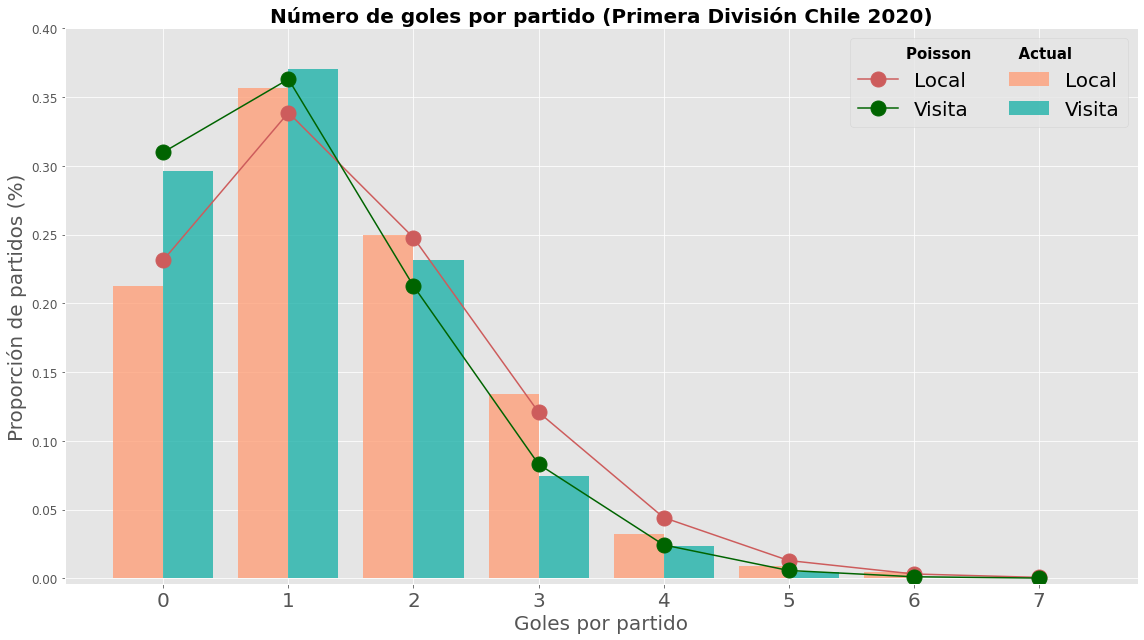

In [250]:
N_poisson = 8
poisson_pred = np.column_stack([[poisson.pmf(i, df[j].mean()) for i in range(N_poisson)] for j in ['GL','GV']])

#Graficar distribución actual de goles en el torneo
plt.hist(df[['GL','GV']].values, range(9), density = True, label = ['Local','Visita'], 
         alpha = 0.8, color=["#FFA07A", "#20B2AA"])

#Graficar predicción de goles según tasas de poisson (promedios local-visita)
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0], 
                  linestyle ='-', marker = 'o', label ='Local', color ='#CD5C5C', ms = 15)
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1], 
                  linestyle= '-', marker= 'o', label ='Visita', color ='#006400', ms = 15)

#Atributos del gráfico
leg = plt.legend(loc ='upper right', fontsize = 20, ncol = 2)
leg.set_title("Poisson         Actual", prop = {'size':'15', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)], size = 20)
plt.yticks(size = 12)
plt.xlabel("Goles por partido",size=20)
plt.ylabel("Proporción de partidos (%)",size=20)
plt.title("Número de goles por partido (Primera División Chile 2020)",size=20,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.savefig("poisson_dist.png")
plt.show()

## Ajustar modelo

Con datos de torneo 2020, solo partidos jugados

In [8]:
df_played = df[df.Jugado == 1]
goal_model_data = pd.concat([df_played[['Local','Visita','GL']].assign(Localia=1).rename(
            columns={'Local':'Equipo','Visita':'Rival','GL':'Goles'}),
           df_played[['Visita','Local','GV']].assign(Localia=0).rename(
            columns={'Visita':'Equipo','Local':'Rival','GV':'Goles'})])

poisson_model = smf.glm(formula="Goles ~ Localia + Equipo + Rival", data = goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goles   No. Observations:                  432
Model:                            GLM   Df Residuals:                      396
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -601.19
Date:                Sat, 26 Dec 2020   Deviance:                       428.62
Time:                        16:29:23   Pearson chi2:                     358.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0224      0.265     -0.084      0.933      -0.543       0.498
Equipo[T.Audax Italiano]                0.0519      0.246      0.211      0.833      -0.430       0.534
Equipo[T.Cobresal]                     -0.0586      0.256     -0.229      0.819      -0.560       0.443
Equipo[T.Colo-Colo]                    -0.2102      0.266     -0.790      0.429      -0.732       0.311
Equipo[T.Coquimbo Unido]               -0.3480      0.277     -1.258      0.208      -0.890       0.194
Equipo[T.Curicó Unido]                 -0.1066      0.258     -0.413      0.679      -0.612       0.399
Equipo[T.Everton]                      -0.0748      0.254     -0.294      0.768      -0.573       0.423
Equipo[T.Huachipato]                   -0.0990      0.257     -0.386      0.700      -0.602       0.404
Equipo[T.Iquique]                      -0.1326      0.263     -0.503      0.615      -0.649       0.384
Equipo[T.La Serena]                    -0.2175      0.263     -0.826      0.409      -0.734       0.298
Equipo[T.O'Higgins]                    -0.0092      0.255     -0.036      0.971      -0.510       0.491
Equipo[T.Palestino]                    -0.1190      0.259     -0.460      0.645      -0.626       0.388
Equipo[T.Santiago Wanderers]            0.0535      0.249      0.215      0.830      -0.435       0.543
Equipo[T.Universidad Católica]          0.5462      0.227      2.404      0.016       0.101       0.992
Equipo[T.Universidad de Chile]          0.1825      0.240      0.760      0.448      -0.288       0.653
Equipo[T.Universidad de Concepción]    -0.0614      0.254     -0.242      0.809      -0.560       0.437
Equipo[T.Unión Española]                0.2796      0.234      1.195      0.232      -0.179       0.738
Equipo[T.Unión La Calera]               0.3476      0.236      1.472      0.141      -0.115       0.810
Rival[T.Audax Italiano]                 0.3396      0.249      1.362      0.173      -0.149       0.828
Rival[T.Cobresal]                       0.0823      0.264      0.312      0.755      -0.435       0.600
Rival[T.Colo-Colo]                      0.2560      0.253      1.012      0.312      -0.240       0.752
Rival[T.Coquimbo Unido]                 0.2436      0.253      0.961      0.336      -0.253       0.740
Rival[T.Curicó Unido]                   0.2203      0.258      0.854      0.393      -0.285       0.726
Rival[T.Everton]                        0.0703      0.263      0.268      0.789      -0.445       0.585
Rival[T.Huachipato]                     0.1115      0.263      0.424      0.671      -0.403       0.626
Rival[T.Iquique]                        0.1907      0.262      0.728      0.467      -0.323       0.704
Rival[T.La Serena]                      0.0467      0.266      0.17

## Simulación

In [9]:
np.random.seed(42)

In [233]:
N_sim = 1000
df_tabla_2020 = current_table(df, teams)
sim_poisson_local, sim_poisson_visita = poisson_tournament(df, poisson_model, N = N_sim)
df_posicion = summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019, df_tabla_2020)

90it [00:00, 95.57it/s] 
  0%|          | 0/1000 [00:00<?, ?it/s]

0:00:01.031562


100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]


In [234]:
df_desc_stats = relegation_stats(N_sim, df_posicion)
df_desc_stats

,n_sim,Equipo,Desc,Motivo
0,1,Coquimbo Unido,1,Último Absoluta
1,1,Iquique,2,Último Ponderada
2,1,Universidad de Concepción,3,Partido Pen Abs vs Pen Pon
3,2,Colo-Colo,1,Último Absoluta
4,2,Universidad de Concepción,2,Último Ponderada
...,...,...,...,...
2995,999,Universidad de Concepción,2,Último Ponderada
2996,999,Colo-Colo,3,Partido Pen Abs vs Pen Pon
2997,1000,Colo-Colo,1,Último Absoluta
2998,1000,La Serena,2,Último Ponderada


In [235]:
prob_desc = df_desc_stats.Equipo.value_counts()/N_sim
prob_desc

Universidad de Concepción    0.791
Iquique                      0.603
Coquimbo Unido               0.600
Colo-Colo                    0.574
Santiago Wanderers           0.175
Audax Italiano               0.108
La Serena                    0.097
O'Higgins                    0.019
Cobresal                     0.007
Curicó Unido                 0.007
Everton                      0.007
Palestino                    0.006
Universidad de Chile         0.005
Huachipato                   0.001
Name: Equipo, dtype: float64

In [249]:
summary_reasons = pd.pivot_table(df_desc_stats, index = "Equipo", columns = "Desc", values = "Motivo", 
                                 aggfunc = "count").fillna(0)/N_sim
summary_reasons = summary_reasons.loc[prob_desc.index]
summary_reasons["Prob Desc"] = summary_reasons["1"] + summary_reasons["2"] + summary_reasons["3"]
summary_reasons

Desc,1,2,3,Prob Desc
Universidad de Concepción,0.017,0.548,0.226,0.791
Iquique,0.034,0.316,0.253,0.603
Coquimbo Unido,0.466,0.000,0.134,0.600
Colo-Colo,0.419,0.000,0.155,0.574
Santiago Wanderers,0.012,0.092,0.071,0.175
Audax Italiano,0.042,0.000,0.066,0.108
La Serena,0.001,0.042,0.054,0.097
O'Higgins,0.006,0.000,0.013,0.019
Cobresal,0.000,0.000,0.007,0.007
Curicó Unido,0.000,0.000,0.007,0.007
